# Интерполяционный подход к решению задач теории расписаний
Вопросы:
1. Теперь, получается, времена поступления не целочисленны?

In [242]:
import json
import time
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import moment
from itertools import permutations
from ipywidgets import IntProgress
from IPython.display import display
from scipy.interpolate import lagrange
from IPython.display import clear_output

In [224]:
timeout = 120
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.cumsum(np.random.exponential(scale=1/LAMBDA, size=(a,)))
            ps = np.clip(np.random.normal(MU, SIGMA, size=(a,)), a_min=0, a_max=None)
            ds = [r + VARK*moment(ps, moment=2) for r in rs]
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale_r(self, alpha):
        self.array[:,0] = self.array[:,0]*alpha
        return self
    
def dual(N, tau, B):
    if len(N.without(B)) == 0: return float('inf')
    pi_r = r(np.argsort(N, axis=0).transpose())
    bestL = N[pi_r].L(tau=tau)
    for i_k in pi_r:
        toDrop = B.copy()
        toDrop.append(i_k)
        #print(toDrop)
        s = N.without(toDrop)
        #print(s)
        if len(s) != 0:
            task_l = min(s, key=r)
            i_l = N.find(task_l)[0]
            pi_k = remove(pi_r, [i_l, i_k])
            pi_k = np.insert(pi_k, 0, i_l)
            pi_k = np.append(pi_k, i_k)
            L_k = N[pi_k].L(tau=tau)
            if L_k < bestL:
                bestL = L_k
    additionalL = N[pi_r].L(i=0, tau=tau)
    if additionalL > bestL:
        bestL = additionalL
    return bestL

class Instance:
    
    def __init__(self, N, tau=0, pi=[], B=[]):
        self.N = N.copy()
        self.tau = tau
        self.pi = pi.copy()
        self.B = B.copy()
        self.nu = dual(N, tau, B)
        
    def __getitem__(self, key):
        return TaskSet(self.N.array[key])
        
    def best_job(self):
        s = self.N.without(self.B)
        sn = s[r(s.transpose()) <= self.tau]
        if len(sn) == 0:
            f = min(s, key=r)
            #self.tau = r(f)
            #self.nu = dual(self.N, self.tau, self.B)
        else:
            f = min(sn, key=d)
        return self.N.find(f)[0]
    
    def L(self, i=None):
        return self[self.pi].L(i, self.tau)
    
    def T(self, i=None):
        return self[self.pi].T(i, self.tau)
        
    def L_max(self):
        return self[self.pi].L_max(self.tau)
    
    def T_max(self):
        return self[self.pi].T_max(self.tau)
    
    def __repr__(self):
        return "Instance:\n" + repr(self.N) + "\nnu  = " + str(self.nu) + "\ntau = " + str(self.tau) + "\npi  = " + str(self.pi) + "\nB   = " + str(self.B)
    
    
def main(N, tau=0, verbose=False, modified=False):
    tb = time.time()
    b_counter = 0
    #print("bi")
    instances = [Instance(N, tau)]
    #print("ai")
    if modified: bestPi = list(range(len(N)))
    else: bestPi = []
    while len(instances) > 0:
        ti = time.time()
        if ti - tb > timeout:
            return TaskSet([]), -1
        bestInstanceIndex, bestInstance = min(enumerate(instances), key=lambda x: x[1].nu) # + N[x[1].pi].L_max(tau))
        instances.pop(bestInstanceIndex)
        f = bestInstance.best_job()
        f_data = bestInstance[f]
        N1 = bestInstance.N.without(f)
        tau1 = max(r(f_data), bestInstance.tau) + p(f_data)
        B1 = []
        pi1 = bestInstance.pi.copy()
        pi1.append(N.find(f_data)[0])
        i1 = Instance(N1, tau1, pi1, B1)
        N2 = bestInstance.N
        tau2 = bestInstance.tau
        B2 = bestInstance.B.copy()
        B2.append(N2.find(f_data)[0]) #!
        pi2 = bestInstance.pi
        i2 = Instance(N2, tau2, pi2, B2)
        instances += [i1, i2]
        b_counter += 1
        #print(i1)
        if len(pi1) == len(N):
            #print(N[bestPi].L_max(tau))
            #print(pi1)
            if N[pi1].L_max(tau) < N[bestPi].L_max(tau):
                bestPi = pi1.copy()
                if verbose: print(bestPi, '\tLmax =', N[bestPi].L_max(tau))
        #lb = len(instances)
        instances = [i for i in instances if max(i.nu, N[i.pi].L_max(tau)) < N[bestPi].L_max(tau)]
        #print(lb, len(instances))
    return bestPi, b_counter
        

In [225]:
def parse_str(s):
    s = np.array(s.replace(',', ' ').split(), dtype=float)
    s = s.reshape((len(s)//3, 3))
    return s

schedules = []
for fname in glob.glob("./tasks/*.txt"):
    file = open(fname, 'r')
    a = np.array(list(f.split() for f in file.readlines()[:-2])).astype(float)
    schedules.append(TaskSet(a))

# Прямая в n-мерном пространстве

In [228]:
#alphaRange = remove(np.arange(0, 2, 0.1), 1.)
alphaRange = np.arange(0, 2.1, 0.1)

In [229]:
def linear_equation(x, x1, x2):
    return (x - x1) / (x2 - x1)

In [237]:
for n, s in enumerate(schedules):
    scaledSchedules = []
    #s = TaskSet(10)
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    
    pointResults = []
    s1, s2 = flattenedScaledSchedules[:2]
    for s in flattenedScaledSchedules[2:]:
        linearEqResults = []
        for index, x1 in enumerate(s1):
            x2 = s2[index]
            x = s[index]
            if x2 != x1: linearEqResults.append(linear_equation(x, x1, x2))
        pointResults.append(np.all(np.isclose(linearEqResults, linearEqResults[0])))
    print("В примере %s все точки - на одной прямой:" % n, np.all(pointResults))

В примере 0 все точки - на одной прямой: True
В примере 1 все точки - на одной прямой: True
В примере 2 все точки - на одной прямой: True
В примере 3 все точки - на одной прямой: True
В примере 4 все точки - на одной прямой: True
В примере 5 все точки - на одной прямой: True
В примере 6 все точки - на одной прямой: True
В примере 7 все точки - на одной прямой: True
В примере 8 все точки - на одной прямой: True
В примере 9 все точки - на одной прямой: True


In [238]:
for n, s in enumerate(schedules):
    scaledSchedules = []
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    
    print("\rCurrently working with", n)
    approxResults = []
    if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
    prgBar = IntProgress(min = 0, max = len(alphaRange))
    display(prgBar)
    for i, a in enumerate(alphaRange):
        s = scaledSchedules[i]
        bestPi, bestCounter = main(s, verbose=False)
        prgBar.value = prgBar.value + 1
        if s[bestPi].L_max() != float('inf'):
            approxResults.append((a, s[bestPi].L_max()))
    
    with open("easyapprox%s.json" % n, 'w') as f:
        json.dump(approxResults, f)
print("\rDone!")

Currently working with 0


IntProgress(value=0, max=21)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Currently working with 1


IntProgress(value=0, max=21)

Currently working with 2


IntProgress(value=0, max=21)

Currently working with 3


IntProgress(value=0, max=21)

Currently working with 4


IntProgress(value=0, max=21)

Currently working with 5


IntProgress(value=0, max=21)

Currently working with 6


IntProgress(value=0, max=21)

Currently working with 7


IntProgress(value=0, max=21)

KeyboardInterrupt: 

In [244]:
N_TASKS = 100
mPrgBar = IntProgress(min = 0, max = N_TASKS)
display(mPrgBar)
prgBar = IntProgress(min = 0, max = len(alphaRange))
display(prgBar)
for n in range(N_TASKS):
    scaledSchedules = []
    s = TaskSet(10)
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    
    print("\rCurrently working with", n)
    approxResults = []
    if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
    
    prgBar.value = 0
    for i, a in enumerate(alphaRange):
        s = scaledSchedules[i]
        bestPi, bestCounter = main(s, verbose=False)
        prgBar.value = prgBar.value + 1
        if s[bestPi].L_max() != float('inf'):
            approxResults.append((a, s[bestPi].L_max()))
    
    with open("./approx/easyapprox%s.json" % n, 'w') as f:
        json.dump(approxResults, f)
    mPrgBar.value = mPrgBar.value + 1
print("\rDone!")

IntProgress(value=0)

IntProgress(value=0, max=21)

Currently working with 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Currently working with 1
Currently working with 2


KeyboardInterrupt: 

In [ ]:
approxResults = np.array(approxResults)
trueIndex = np.where(np.isclose(approxResults[:,0], 1.))[0][0]
trueValue = approxResults[trueIndex]
approxResults = np.delete(approxResults, trueIndex, axis=0)

In [223]:
approxResults

array([[ 0.00000000e+00, -1.74104728e+03],
       [ 1.00000000e-01, -1.73169377e+03],
       [ 2.00000000e-01, -1.72234027e+03],
       [ 3.00000000e-01, -1.71298676e+03],
       [ 4.00000000e-01, -1.70363326e+03],
       [ 5.00000000e-01, -1.69427975e+03],
       [ 6.00000000e-01, -1.68492624e+03],
       [ 7.00000000e-01, -1.67557274e+03],
       [ 8.00000000e-01, -1.66621923e+03],
       [ 9.00000000e-01, -1.65686573e+03],
       [ 1.10000000e+00, -1.63815872e+03],
       [ 1.20000000e+00, -1.62880521e+03],
       [ 1.30000000e+00, -1.60554386e+03],
       [ 1.40000000e+00, -1.52591760e+03],
       [ 1.50000000e+00, -1.44629134e+03],
       [ 1.60000000e+00, -1.36666507e+03],
       [ 1.70000000e+00, -1.28703881e+03],
       [ 1.80000000e+00, -1.20741254e+03],
       [ 1.90000000e+00, -1.12778628e+03]])

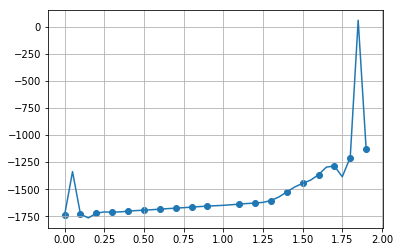

In [205]:
x = approxResults[:,0]
y = approxResults[:,1]
poly = lagrange(x, y)
xp = np.arange(x[0], x[-1], 0.05)
yp = poly(xp)
plt.scatter(x, y)
plt.plot(xp, yp)
plt.grid()

In [222]:
NUM_DIGITS = 2
A = round(trueValue[1], NUM_DIGITS)
B = round(poly(1.), NUM_DIGITS)

pd.DataFrame(data=[[A, B, str(round((B - A)/A*100, NUM_DIGITS))+'%']], columns=['True value', 'Approx. value', 'Mistake'])

,True value,Approx. value,Mistake
0,-1647.51,-1649.43,0.12%


# Тестирование